# diag_btrop_fluxeb

Diagnose barotropic fluxes and impact of tidal potential based on TPXO8:
* compute fluxes (to be compared with simulations)
* compute fluxes across boundaries (is it positiv in TPXO ?)
* compute tidal potential work $<gH\vec{\overline{U}}\cdot\vec{\nabla}P_\text{tide}>$ (cf. croco)

*(NJAL June 25th 2018)*

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
import scipy.interpolate as itp

krypton = "/data0/project/vortex/lahaye/"
alpha = "/net/alpha/exports/sciences/data/REFERENCE_DATA/TIDES/"
ruchba = krypton + "local_ruchba/"

In [3]:
rho0, grav = 1.025, 9.81
Erad = 6371e3

# convert complex to amplitude+phase (radians)
def cmp2ap(re,im):
    return np.abs(re+1j*im),np.arctan2(-im,re)

# interpolate from u-, v- points to z-points
def u2rho(lon_u, data, lon_r):
    return itp.pchip_interpolate(lon_u, data, lon_r, axis=-1)

def v2rho(lat_v, data, lat_r):
    return itp.pchip_interpolate(lat_v, data, lat_r, axis=-2)

def rotuv(uu, vv, ang):
    return uu*np.cos(ang) + vv*np.sin(ang), -uu*np.sin(ang) + vv*np.cos(ang)

def div_on_grid(uu, vv, pm, pn):
    dudx = (uu[:,1:] - uu[:,:-1])*0.5*(pm[:,1:] + pm[:,:-1])
    dudx = 0.5 * np.pad( dudx[:,:-1]+dudx[:,1:], ((0,0),(1,1)), mode="edge" )
    dvdy = (vv[1:,:] - vv[:-1,:])*0.5*(pn[1:,:] + pn[:-1,:])
    dvdy = 0.5 * np.pad( dvdy[1:,:]+dvdy[:-1,:], ((1,1),(0,0)), mode="edge" )
    return dudx + dvdy

def grad_on_grid(uu, pm, pn):
    dudx = (uu[:,1:] - uu[:,:-1])*0.5*(pm[:,1:] + pm[:,:-1])
    dudx = 0.5 * np.pad( dudx[:,:-1]+dudx[:,1:], ((0,0),(1,1)), mode="edge" )
    dvdy = (uu[1:,:] - uu[:-1,:])*0.5*(pn[1:,:] + pn[:-1,:])
    dvdy = 0.5 * np.pad( dvdy[1:,:]+dvdy[:-1,:], ((1,1),(0,0)), mode="edge" )
    return dudx, dvdy

In [4]:
# load LUCKY's grid

ncgrd = Dataset(krypton+'lucky_corgrd.nc','r')
h = ncgrd.variables['h'][:]
lon_h = ncgrd.variables['lon_rho'][:]
lat_h = ncgrd.variables['lat_rho'][:]
mask = ncgrd.variables['mask_rho'][:]
grang = ncgrd.variables['angle'][:]
pm = ncgrd.variables['pm'][:]
pn = ncgrd.variables['pn'][:]
ncgrd.close()

# load tidal potential from LUCKY's forcing file
ncfrc = Dataset(ruchba+'prep_LUCKYTO/luckym2_frc.nc')
potamp = ncfrc.variables['tide_Pamp'][0,:,:]
potpha = np.deg2rad(ncfrc.variables['tide_Pphase'][0,:,:])
ncfrc.close()

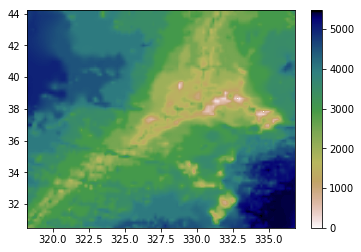

In [5]:
# load tpxo8 data : dealing with transport ! (warning)
nc = Dataset(alpha+"TPXO8/uv.m2_tpxo8_atlas_30c_v1.nc",'r')
ncvar = nc.variables

lonu = ncvar['lon_u'][:]
indxu, = np.where( (lonu>=(lon_h%360).min()) & (lonu<=(lon_h%360).max()) )
lonu = lonu[indxu]
latu = ncvar['lat_u'][:]
indyu, = np.where( (latu>=lat_h.min()) & (latu<=lat_h.max()) )
latu = latu[indyu]
lonv = ncvar['lon_v'][:]
indxv, = np.where( (lonv>=(lon_h%360).min()) & (lonv<=(lon_h%360).max()) )
lonv = lonv[indxv]
latv = ncvar['lat_v'][:]
indyv, = np.where( (latv>=lat_h.min()) & (latv<=lat_h.max()) )
latv = latv[indyv]

ure = ncvar['uRe'][indxu,indyu].T*1e-4    # cm²/s to m²/s
vre = ncvar['vRe'][indxv,indyv].T*1e-4
uim = ncvar['uIm'][indxu,indyu].T*1e-4
vim = ncvar['vIm'][indxv,indyv].T*1e-4

nc.close()

# now load SSH
nc = Dataset(alpha+"TPXO8/hf.m2_tpxo8_atlas_30c_v1.nc",'r')
ncvar = nc.variables

lonr = ncvar['lon_z'][:]
indx, = np.where( (lonr>=(lon_h%360).min()) & (lonr<=(lon_h%360).max()) )
lonr = lonr[indx]
latr = ncvar['lat_z'][:]
indy, = np.where( (latr>=lat_h.min()) & (latr<=lat_h.max()) )
latr = latr[indy]

zre = ncvar['hRe'][indx,indy].T*1e-3     # mm to m
zim = ncvar['hIm'][indx,indy].T*1e-3

nc.close()

nc = Dataset(alpha+"TPXO8/grid_tpxo8_atlas_30c_v1.nc",'r')
topox = nc.variables['hz'][indx,indy].T
nc.close()

plt.pcolormesh(lonr,latr, topox, cmap="gist_earth_r")
plt.colorbar()

5.39163189836


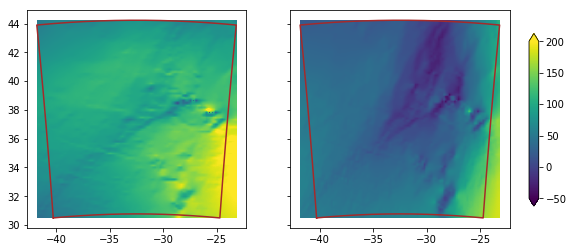

In [6]:
# convert Re, Im to phase, amplitude, interpolate u, v and z-grid and plot fluxes
cmap = None
pumin = -50
pumax = 200

uamp, upha = cmp2ap(ure, uim)
vamp, vpha = cmp2ap(vre, vim)
zamp, zpha = cmp2ap(zre, zim)

puamp = rho0*grav*u2rho(lonu,uamp,lonr)*zamp*np.cos(u2rho(lonu,upha,lonr)-zpha)/2.
pvamp = rho0*grav*v2rho(latv,vamp,latr)*zamp*np.cos(v2rho(latv,vpha,latr)-zpha)/2.

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))
hpc = axs[0].pcolormesh(lonr-360, latr, puamp, cmap=cmap, vmin=pumin, vmax=pumax)
axs[1].pcolormesh(lonr-360, latr, pvamp, cmap=cmap, vmin=pumin, vmax=pumax)

axs[0].plot(np.r_[lon_h[0,:],lon_h[:,-1],lon_h[-1,::-1],lon_h[::-1,0]] \
           , np.r_[lat_h[0,:],lat_h[:,-1],lat_h[-1,::-1],lat_h[::-1,0]], color="brown")
axs[1].plot(np.r_[lon_h[0,:],lon_h[:,-1],lon_h[-1,::-1],lon_h[::-1,0]] \
           , np.r_[lat_h[0,:],lat_h[:,-1],lat_h[-1,::-1],lat_h[::-1,0]], color="brown")
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])
fig.colorbar(hpc, cax=cbar_ax, extend="both")

# What is going out ?
dy = np.deg2rad(np.diff(latr).mean())*Erad
dxb = np.deg2rad(np.diff(lonr).mean())*Erad*np.cos(np.deg2rad(latr[0]))
dxt = np.deg2rad(np.diff(lonr).mean())*Erad*np.cos(np.deg2rad(latr[-1]))
Surf = dy*len(latr)*(dxb+dxt)/2.*len(lonr)

# this seems wrong
pvout = ( (puamp[:,-1]-puamp[:,0]).sum()*dy + (pvamp[-1,:]*dxt-pvamp[0,:]*dxb).sum() ) / Surf
print(pvout*1e6)

fluxamp_lonlat = np.sqrt(puamp**2 + pvamp**2)

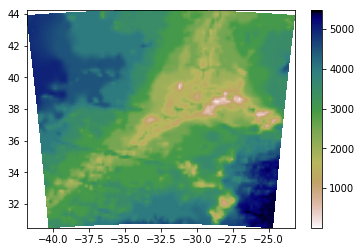

In [7]:
### Interpolate fields on Lucky's grid

# load tpxo8 data : dealing with transport ! (warning)
nc = Dataset(alpha+"TPXO8/uv.m2_tpxo8_atlas_30c_v1.nc",'r')
ncvar = nc.variables

lonu = ncvar['lon_u'][:]
indxu, = np.where( (lonu>=(lon_h%360).min()) & (lonu<=(lon_h%360).max()) )
indxu = slice(indxu[0]-1, indxu[-1]+1)
lonu = lonu[indxu]
latu = ncvar['lat_u'][:]
indyu, = np.where( (latu>=lat_h.min()) & (latu<=lat_h.max()) )
indyu = slice(indyu[0]-1, indyu[-1]+1)
latu = latu[indyu]
lonv = ncvar['lon_v'][:]
indxv, = np.where( (lonv>=(lon_h%360).min()) & (lonv<=(lon_h%360).max()) )
indxv = slice(indxv[0]-1, indxv[-1]+1)
lonv = lonv[indxv]
latv = ncvar['lat_v'][:]
indyv, = np.where( (latv>=lat_h.min()) & (latv<=lat_h.max()) )
indyv = slice(indyv[0]-1, indyv[-1]+1)
latv = latv[indyv]

ure = ncvar['uRe'][indxu,indyu]*1e-4    # cm²/s to m²/s
ure = itp.RectBivariateSpline(latu, lonu-360, ure.T).ev(lat_h,lon_h)
uim = ncvar['uIm'][indxu,indyu]*1e-4    
uim = itp.RectBivariateSpline(latu, lonu-360, uim.T).ev(lat_h,lon_h)
vre = ncvar['vRe'][indxv,indyv]*1e-4    
vre = itp.RectBivariateSpline(latv, lonv-360, vre.T).ev(lat_h,lon_h)
vim = ncvar['vIm'][indxv,indyv]*1e-4    
vim = itp.RectBivariateSpline(latv, lonv-360, vim.T).ev(lat_h,lon_h)

nc.close()

# SSH
nc = Dataset(alpha+"TPXO8/hf.m2_tpxo8_atlas_30c_v1.nc",'r')
ncvar = nc.variables

lonr = ncvar['lon_z'][:]
indx, = np.where( (lonr>=(lon_h%360).min()) & (lonr<=(lon_h%360).max()) )
indx = slice(indx[0]-1, indx[-1]+1)
lonr = lonr[indx]
latr = ncvar['lat_z'][:]
indy, = np.where( (latr>=lat_h.min()) & (latr<=lat_h.max()) )
indy = slice(indy[0]-1, indy[-1]+1)
latr = latr[indy]

zre = ncvar['hRe'][indx,indy]*1e-3     # mm to m
zre = itp.RectBivariateSpline(latr, lonr-360, zre.T).ev(lat_h,lon_h)
zim = ncvar['hIm'][indx,indy]*1e-3
zim = itp.RectBivariateSpline(latr, lonr-360, zim.T).ev(lat_h,lon_h)

nc.close()

# bathymetry
nc = Dataset(alpha+"TPXO8/grid_tpxo8_atlas_30c_v1.nc",'r')
lonr = nc.variables['lon_z'][:]
indx, = np.where( (lonr>=(lon_h%360).min()) & (lonr<=(lon_h%360).max()) )
indx = slice(indx[0]-1, indx[-1]+1)
lonr = lonr[indx]
latr = nc.variables['lat_z'][:]
indy, = np.where( (latr>=lat_h.min()) & (latr<=lat_h.max()) )
indy = slice(indy[0]-1, indy[-1]+1)
latr = latr[indy]

topox = nc.variables['hz'][indx,indy]
topox = itp.RectBivariateSpline(latr, lonr-360, topox.T).ev(lat_h,lon_h)

nc.close()

# apply rotation to transport field
ure, vre = rotuv(ure, vre, grang)
uim, vim = rotuv(uim, vim, grang)

plt.figure()
plt.pcolormesh(lon_h, lat_h, topox, cmap="gist_earth_r")
plt.colorbar()

5.00738976653 11.2370923959


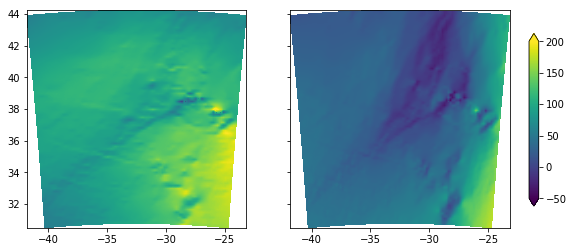

In [12]:
# compute modal flux and plot it, compute what is going out
# convert Re, Im to phase, amplitude, interpolate u, v and z-grid and plot fluxes
cmap = None
pumin = -50
pumax = 200

uamp, upha = cmp2ap(ure, uim)
vamp, vpha = cmp2ap(vre, vim)
zamp, zpha = cmp2ap(zre, zim)

puamp = rho0*grav*uamp*zamp*np.cos(upha-zpha)/2.
pvamp = rho0*grav*vamp*zamp*np.cos(vpha-zpha)/2.

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))
hpc = axs[0].pcolormesh(lon_h, lat_h, puamp, cmap=cmap, vmin=pumin, vmax=pumax)
axs[1].pcolormesh(lon_h, lat_h, pvamp, cmap=cmap, vmin=pumin, vmax=pumax)

fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])
fig.colorbar(hpc, cax=cbar_ax, extend="both")

# What is going out ? this looks like a better estimate
Surf = (1./pm/pn).sum()
pvout = ( (puamp[:,-1]/pn[:,-1]-puamp[:,0]/pn[:,0]).sum() \
         + (pvamp[-1,:]/pm[-1,:]-pvamp[0,:]/pm[0,:]).sum() ) / Surf
print(pvout*1e6, pvout*Surf/1e6)

fluxamp_curv = np.sqrt(puamp**2 + pvamp**2)

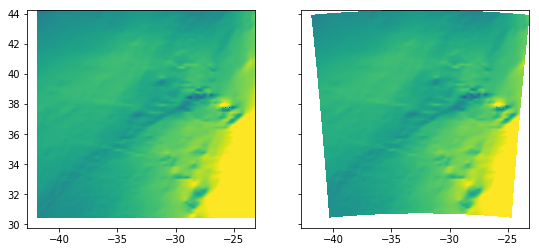

In [9]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))
axs[0].pcolormesh(lonr-360, latr, fluxamp_lonlat, vmin=-50, vmax=200)
axs[1].pcolormesh(lon_h, lat_h, fluxamp_curv, vmin=-50, vmax=200)


4.86688824393 4.87034586807


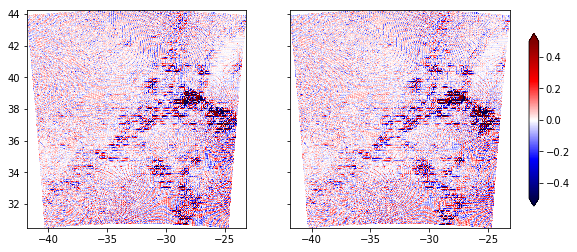

In [15]:
# compute and plot divergence of barotropic flux

divf = div_on_grid(puamp, pvamp, pm, pn)*1e3 # W/m²
dx, dy = (1./pm).mean(), (1./pn).mean()
dibf = ( np.gradient(puamp, dx, axis=-1) + np.gradient(pvamp, dy, axis=-2) ) * 1e3

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))

hpc = axs[0].pcolormesh(lon_h, lat_h, divf, cmap='seismic', vmin=-0.5, vmax=0.5)
axs[1].pcolormesh(lon_h, lat_h, dibf, cmap='seismic', vmin=-0.5, vmax=0.5)

fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])
fig.colorbar(hpc, cax=cbar_ax, extend="both")

print(np.nanmean(divf)*1e3, np.nanmean(dibf)*1e3)

11.277249771 25.3072965271


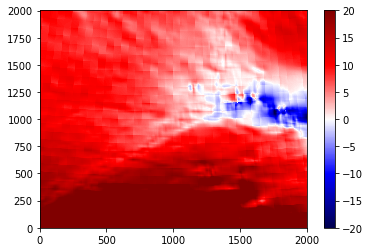

In [17]:
# compute and plot tidal potential work term
dpamp_dx, dpamp_dy = grad_on_grid(potamp, pm, pn)
dphat_dx, dphat_dy = grad_on_grid(potpha, pm, pn)

fpotx = uamp*( dpamp_dx*np.cos(upha-potpha) - potamp*dphat_dx*np.sin(upha-potpha) )
fpoty = vamp*( dpamp_dy*np.cos(vpha-potpha) - potamp*dphat_dy*np.sin(vpha-potpha) )

fpot = rho0*grav*(fpotx + fpoty)*1e6   # mW/m²

plt.pcolormesh(fpot, vmin=-20, vmax=20, cmap='seismic')
plt.colorbar()

print(np.nanmean(fpot), np.nanmean(fpot)*Surf/1e12)